## Para gerar as as imagem execute data.py que está na pasta data_pendulo


## As funções uteis estão no arquivo fuction.py

In [1]:
from fuction import *

Treinamento concluído


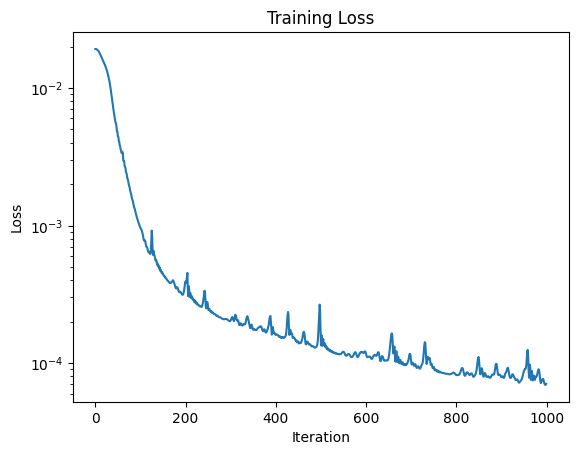

In [2]:
# Caminho para o diretório das imagens
root_dir = 'data_pendulo'  # Ajuste para o diretório onde suas imagens estão salvas

# DataLoader
batch_size = 30
dataset = CustomImageDataset(root_dir)
model = SimpleAutoencoder(neck=2)  # Ajuste o parâmetro 'neck' conforme necessário

trainer = Trainer(model, dataset, batch_size=batch_size,step_size=300,device="cuda")
trainer.train(epochs=5000)

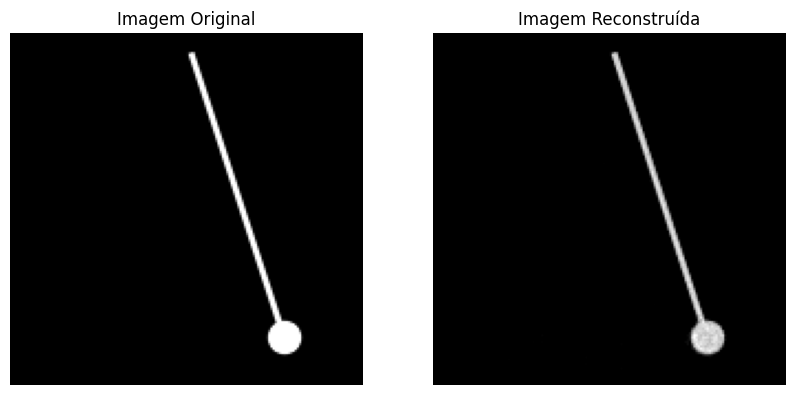

In [3]:
trainer.model.eval()  # Coloca o modelo em modo de avaliação

# Supondo que você quer testar com a primeira imagem do dataset
dataiter = iter(trainer.dataloader)
images = next(dataiter)
# Executar a imagem pela rede
output,output2 = trainer.model(images[0].unsqueeze(0).to("cuda"))

# Converte a saída do modelo e a entrada para exibição
output = output.cpu().detach().numpy().squeeze()
input_image = images[0].cpu().detach().numpy().squeeze()

# Plotando as imagens
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_image, cmap='gray')
ax[0].set_title('Imagem Original')
ax[0].axis('off')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Imagem Reconstruída')
ax[1].axis('off')
plt.show()

In [17]:
trainer.model.eval()  # Coloca o modelo em modo de avaliação

for i, data in enumerate(trainer.dataloader, 0):
    data = data.to("cuda")  # Move data to GPU
    output,output2 = trainer.model(data)
latente = output2.cpu().detach().numpy()


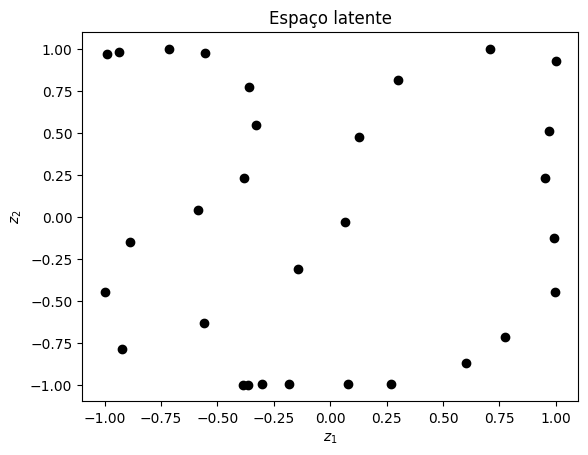

In [29]:
plt.plot( latente[:,0] ,latente[:,1],'ko' )
plt.title("Espaço latente")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.show()